# Extracting Graphs from Hara Datasets
---
> Preprocessing amnioserosa movies (spinning disk) and ablation movies (confocal) from Hara et al. 2016

|     Dataset |Frame rate (s)|Pixel size (micron)|
|------------:|-------------:|------------------:|
|  Hara movies|       1      |        0.21       |
|Hara ablation|      10      |        0.40       |

- for loading and processing Hara movies and reading Hara ablation dataset (for extracting nodes use section w/ napari)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx, pandas as pd, glob
from simgnn.datautils import simple_moving_average, mknewdir, write_array, load_array, load_graph
from simgnn.hara import get_cell_colormap, read_tiff_stack, label_bw_stack, extract_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7,7) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

from simgnn.datasets import VertexDynamics, HaraMovies, CellData
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


## Hara Movies Dataset
> Processing amnioserosa movies (Hara movies dataset)

### Read TIF files

In [7]:
base_path = path.abspath('../../../dataDIR/example_segmented_data/')

rfp = {path.basename(path.dirname(fname)) : read_tiff_stack(fname) 
       for fname in glob.glob(path.join(base_path,'*Seg*','*RFP*.tif'))}
print(f'RFP channels (cell boundary): {len(rfp)} {rfp.keys()}')

seg = {path.basename(path.dirname(fname)) : read_tiff_stack(fname) 
       for fname in glob.glob(path.join(base_path,'*Seg*','*Seg*.tif'))}
print(f'Segmented boundaries: {len(seg)} {seg.keys()}')

RFP channels (cell boundary): 3 dict_keys(['Seg_001', 'Seg_005', 'Seg_003'])
Segmented boundaries: 3 dict_keys(['Seg_001', 'Seg_005', 'Seg_003'])


### Extract Graphs from Amnioserosa Movies

In [ ]:
root_dir = 'simgnn_data/hara_movies/raw/'
PROCESS_HARA_MOVIE = False # set to true to process Hara AS tissue movies

if PROCESS_HARA_MOVIE:
    for bw_img in seg:
        edges_index, node2cell_index, v_pos = extract_graph(seg[bw_img], label_bw_stack(seg[bw_img])[0])
        edge_lengths = np.sqrt(((v_pos[:,edges_index[1],:] - v_pos[:,edges_index[0],:])**2).sum(axis=-1,keepdims=True))

        dataDir = path.join(root_dir, bw_img)
        mknewdir(dataDir);

        write_array(path.join(dataDir, 'edges_index.npy'), edges_index)
        write_array(path.join(dataDir, 'node2cell_index.npy'), node2cell_index)
        write_array(path.join(dataDir, 'vtx_pos.npy'), v_pos)
        write_array(path.join(dataDir, 'edge_Length.npy'), edge_lengths)

### Plotting and verifying tissue graphs

In [9]:
DRAW_GRAPH = True
DRAW_GRAY = True
def draw_frame(t):
    if DRAW_GRAY:
        plt.imshow(rfp[SAMPLE_NAME][t],cmap='gray_r');
    if DRAW_GRAPH:
        # edges
        for e in edges_index.T:
            plt.plot(v_pos[t,e,0],v_pos[t,e,1], color='turquoise', lw=5,alpha=.6)
        # vertices
        plt.plot(v_pos[t,:,0], v_pos[t,:,1],'o',color='purple', alpha=.5,ms=8)
    # axis limits
    plt.title(f"t= {t/6:4.1f} min")
    plt.axis(False);
    plt.axis((-0.5, 510.5, 511.5, -0.5));

In [10]:
SAMPLE_NAME = 'Seg_001'
root_dir = 'simgnn_data/hara_movies/raw/'
dataDir = path.join(root_dir, SAMPLE_NAME)

edges_index = load_array(path.join(dataDir, 'edges_index.npy'))
node2cell_index = load_array(path.join(dataDir, 'node2cell_index.npy'))
v_pos = load_array(path.join(dataDir, 'vtx_pos.npy'))
eij_lens = load_array(path.join(dataDir, 'edge_Length.npy'))

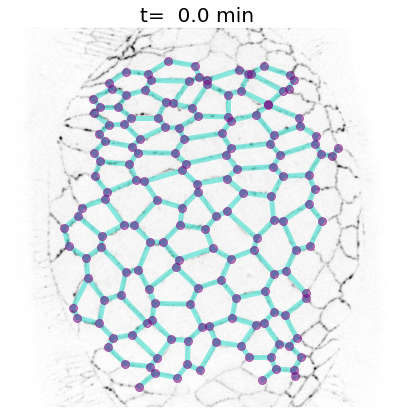

In [11]:
plt.figure(figsize=[7,7])
DRAW_GRAY = True; DRAW_GRAPH = True; t = 0;

draw_frame(t);
# e_id = 147 # --> for drawing selected edges, try with DRAW_GRAPH=False
# plt.plot(v_pos[t,edges_index[:,e_id],0], v_pos[t,edges_index[:,e_id],1],'o-', color='dodgerblue', ms=10)
plt.show()

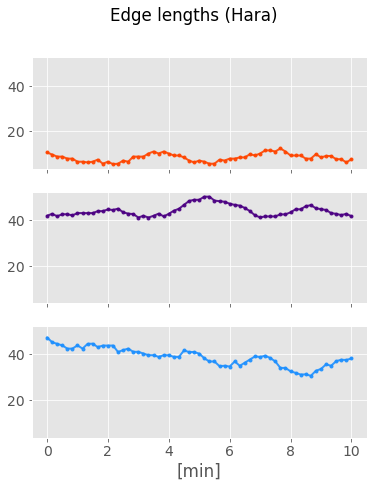

In [18]:
fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True, figsize=[6,7])
t = np.arange(eij_lens.shape[0])/6
for ax,e_id,c in zip(axs,  [14, 119, 147], ['orangered', 'indigo', 'dodgerblue']):
    ax.plot(t,eij_lens[:,e_id],'.-', lw=2, alpha=.9, color = c)
#     ax.plot(t,(eij_lens[:,e_id]-eij_lens[:,e_id].mean())/eij_lens[:,e_id].std(), lw=4, alpha=.8, color = c);#normalised lengths over time
    
# ax.axis([0,60.5/6,-2.9,2.9])
ax.set_xlabel('[min]')
plt.suptitle(f'Edge lengths (Hara)')
plt.show()

#### Save AS Movie Graphs

In [17]:
import PIL

pil_images =[]
DRAW_GRAPH = True # for plotting the extracted graphs
DRAW_GRAY = True # for plotting grayscale (raw) images

# for highlighting edges
SELECT_EDGES = False 
DRAW_e_ij = [124, 102, 29]
COLOR_e_ij = ['orangered', 'indigo', 'dodgerblue']


for i in range(0,rfp[SAMPLE_NAME].shape[0]):
    fig = plt.figure(figsize=[10,10],dpi=60)
    fig.clf(); ax = fig.subplots();
    draw_frame(i)
    if DRAW_GRAPH:
        # edges
        for e in edges_index.T:
            plt.plot(v_pos[i,e,0],v_pos[i,e,1], color='turquoise', lw=5,alpha=.6)
        # vertices
        plt.plot(v_pos[i,:,0], v_pos[i,:,1],'o',color='purple', alpha=.5,ms=8)
    if SELECT_EDGES:
        for e_id,c in zip(DRAW_e_ij,COLOR_e_ij):
            e = edges_index.T[e_id]
            plt.plot(v_pos[i,e,0],v_pos[i,e,1], color=c, lw=5,alpha=.6)
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb()) )
    plt.close()

In [19]:
print(len(pil_images),'; pil0:',pil_images[0].size, '; pil_last', pil_images[-1].size)

61 ; pil0: (600, 600) ; pil_last (600, 600)


In [21]:
# pil_images[0]

- Save the movie as a GIF file

In [15]:
# duration:duration of each frame [s]
# loop : loop the video, see options
# e.g.:
# pil_images[0].save('./gray_oscillations_color_e_ij.gif', format='GIF',
#                   append_images=pil_images[1::3], save_all=True, duration=150, loop=0)

### Compare with Simulated Edges

In [26]:
sim_Data_Dir = './simgnn_data/single_distr_sims/train/raw/27052021_sim000/'
sim_eij_lens = load_array(path.join(sim_Data_Dir, 'simul_Length.npy'))
sim_t = load_array(path.join(sim_Data_Dir, 'simul_t.npy'))
verts_t = load_array(path.join(sim_Data_Dir, 'simul_vtxpos.npy'))
sim_Graph = load_graph(path.join(sim_Data_Dir, 'graph_dict.pkl'))

In [27]:
np.argwhere(np.logical_and((sim_eij_lens.max(axis=0)-sim_eij_lens.min(axis=0))>0.3, (sim_eij_lens.max(axis=0)-sim_eij_lens.min(axis=0))<0.5))[:,0]

array([  5,  90, 264, 271, 319, 457])

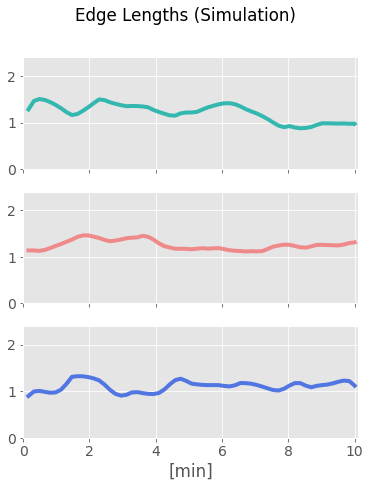

In [29]:
fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True, figsize=[6,7])

edge_ids = [440, 90,319]
COLOR_e_ij = ['lightseagreen', 'lightcoral', 'royalblue']

for ax,e_id,c in zip(axs,  edge_ids, COLOR_e_ij):
    ax.plot(sim_t,sim_eij_lens[:,e_id,0]/sim_eij_lens.mean(),
            lw=4, alpha=.9, color = c);#normalised lengths over time
ax.axis([0,10.1,0,2.4])
ax.set_xlabel('[min]')
plt.suptitle('Edge Lengths (Simulation)')
plt.show()

In [30]:
import networkx as nx
from vertex_simulation.primitives import Vertex, Monolayer, graph2networkx_with_pos, Monolayer

# as a networkx graph
m = Monolayer(vertices=Vertex(verts_t[0]), edges=torch.tensor(sim_Graph['edges'],dtype=torch.long), cells=sim_Graph['cells'])
Gnx,pos=graph2networkx_with_pos(m)
def draw_graph(i):
    '''Draw monolayer frames using networkx draw func-n. Assumes. Static graph, i.e. the graph `Gnx` is constant.
    We pass this function to matplotlib.animation obj.'''
    if isinstance(verts_t[i],  torch.Tensor):
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    else:
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i]))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {sim_t[i]:5.1f} mins',fontsize=50)
    nx.draw(Gnx,pos,node_size=20,width=8,ax=ax,node_color='#FF00FF',edge_color='silver')

In [31]:
import PIL

SELECT_EDGES = False#True

pil_images=[]
for i in range(0,len(verts_t)):
    fig = plt.figure(figsize=[15,15],dpi=40)
    fig.clf()
    ax = fig.subplots()
    ax.axis(False);
    draw_graph(i)
    if SELECT_EDGES:
        for e_ij_x, c in zip(verts_t[i,m.edges[edge_ids],:], COLOR_e_ij):
            plt.plot(e_ij_x[:,0],e_ij_x[:,1],'o-',color=c,ms=15,lw=10)
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb()) )
    plt.close()


- Save simulation as a GIF file

In [32]:
# duration:duration of each frame [s] || loop : loop the video, see options
# pil_images[0].save('./single_distr_sims_27052021_sim000_e_ijs.gif', format='GIF',
#                append_images=pil_images[1::3], save_all=True, duration=150, loop=0)

## Hara Ablation Dataset
> Explore and prepare masks (used for extracting graphs) for ablation movies

In [463]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

In [481]:
recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))
recoil_df.head()

,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,0.023877,0.020217,Expanding,1.104026,1.1-1.5,False,57,4,8,NaN
1,140411_Dacat_recoil,sample3,1,0.464255,-0.043337,Contracting,1.264302,1.1-1.5,False,47,4,9,NaN
2,140411_Dacat_recoil,sample5,1,0.452162,0.019286,Expanding,1.075047,1.0-1.1,False,50,4,8,NaN
3,140411_Dacat_recoil,sample6,1,0.283717,0.006938,Stable,1.331903,1.1-1.5,False,12,4,6,NaN
4,140415_Dacat_recoil,sample1,1,0.524569,-0.052628,Contracting,1.148226,1.1-1.5,False,30,4,8,NaN


### Prepare masks (imageJ)
> Plot tissue and ablated edge, then use this edge location to draw a mask on ImageJ

In [489]:
last_frame_masks = [path.basename(img_name) for img_name in glob.glob(path.join(ablmov_basepath,'frames_masks','*.tif'))]
long_mov_names = recoil_df[recoil_df.AblationFrame>49][['Main folder', 'embryo','Edge ID']]

needs_mask = []
for k in range(len(long_mov_names)):
    mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_mask.tif'
    if mov_name not in last_frame_masks:
        needs_mask.append(k)
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = False
    else:
        long_mov_names.loc[long_mov_names.index[k],'HasMask'] = True

# # long_mov_names.to_csv('/Users/muratshagirov/Desktop/movies_run_avrg/mask_progress.csv')

In [495]:
long_mov_names[(long_mov_names.HasMask)]

,Main folder,embryo,Edge ID,HasMask
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,True
2,140411_Dacat_recoil,sample5,1,True
9,140429_amni_ablation,sample4,1,True
10,140429_amni_ablation,sample4,2,True
11,140429_amni_ablation,sample4,3,True
...,...,...,...,...
162,141212_Dacat_recoil,sample5,1,True
169,141213_Dacat_recoil,sample5,1,True
170,141213_Dacat_recoil,sample6,1,True
172,141213_Dacat_recoil,sample8,1,True


140606_DaCat_recoil_sample3_2.tif
140606_DaCat_recoil_sample3_2_nodes.csv
Image stack shape: (100, 512, 512) -- trim boundaries: False
[171.5, 329.5]


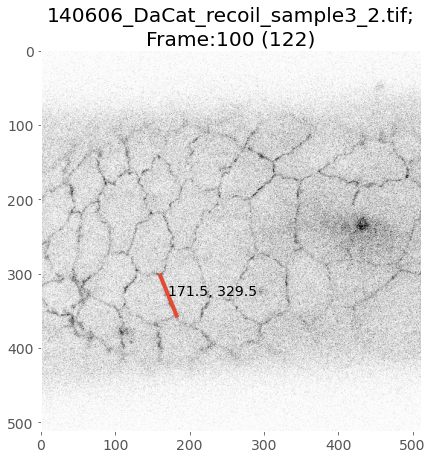

In [497]:
k=needs_mask[0]
mov_name = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'.tif'
print(mov_name)
track_csv = '_'.join([str(long_mov_names.iloc[k][cname]) for cname in ['Main folder', 'embryo', 'Edge ID']])+'_nodes.csv'
print(track_csv)

img = read_tiff_stack(path.join(ablmov_basepath,'movies',mov_name),trim_bound=False)
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',track_csv))
edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print(edge_pos)

plt.imshow(img[-1],cmap='gray_r');plt.grid(False);
plt.plot(node_tracking.iloc[-1,[2,4]], node_tracking.iloc[-1,[3,5]], lw=4);
plt.text(edge_pos[0],edge_pos[1],f'{edge_pos[0]:g}, {edge_pos[1]:g}')
plt.title(f'{mov_name};\nFrame:{node_tracking.iloc[-1].frames:n} ({node_tracking.iloc[-1].t:n})');

# Tracking Ablated Vertices with Napari

**Note** : Restart the jupyter kernel in an env w/ napari !

In [1]:
from skimage import data,io
import napari, numpy as np, glob, pandas as pd
from scipy.interpolate import interp1d
from os import path

from simgnn.datautils import write_array, load_array, mknewdir
from simgnn.hara import read_tiff_stack, mask_to_graph, get_cell_colormap

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

In [2]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

---
- **Load Recoil Data**:

In [3]:
recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))
recoil_df.head()

,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,0.023877,0.020217,Expanding,1.104026,1.1-1.5,False,57,4,8,NaN
1,140411_Dacat_recoil,sample3,1,0.464255,-0.043337,Contracting,1.264302,1.1-1.5,False,47,4,9,NaN
2,140411_Dacat_recoil,sample5,1,0.452162,0.019286,Expanding,1.075047,1.0-1.1,False,50,4,8,NaN
3,140411_Dacat_recoil,sample6,1,0.283717,0.006938,Stable,1.331903,1.1-1.5,False,12,4,6,NaN
4,140415_Dacat_recoil,sample1,1,0.524569,-0.052628,Contracting,1.148226,1.1-1.5,False,30,4,8,NaN


---
- **Select sample name**:

In [4]:
Main_folder = '140529_Dacat_recoil' 
embryo = 'sample15'
Edge_ID = '1'

edge_recoil_val = recoil_df.loc[np.logical_and( np.logical_and(recoil_df['Main folder']==Main_folder, recoil_df['embryo']==embryo),
                         recoil_df['Edge ID']==int(Edge_ID)),'Recoil speed [um/sec]'].values
print(f'Recoil: {edge_recoil_val}')
recoil_df.loc[np.logical_and( np.logical_and(recoil_df['Main folder']==Main_folder, recoil_df['embryo']==embryo),
                         recoil_df['Edge ID']==int(Edge_ID))]

Recoil: [1.08149]


,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
31,140529_Dacat_recoil,sample15,1,1.08149,-0.026289,Contracting,1.022157,1.0-1.1,False,107,4,4,partially occluded 1-neigh-s; close to curved ...


---
- **Load Data and Check the Cell Graph**:

Sample:
 | 140529_Dacat_recoil_sample15_1 
Results will be saved in
 | ./simgnn_data/hara_ablation/raw/140529_Dacat_recoil_sample15_1
Directory already exists.

---
img shape (resampled frames): (10, 512, 512)
Frames:[9, 19, 29, 39, 49, 59, 69, 79, 89, 99]

Node tracks (w/ resampled frames):
     frames    t         x1          y1          x2          y2
9      0.0   16  74.833333  324.833333  165.500000  324.166667
19     1.0   26  74.833333  324.166667  166.166667  324.166667
29     2.0   36  75.166667  324.833333  165.166667  323.500000
39     3.0   46  74.833333  326.166667  165.166667  323.166667
49     4.0   56  76.833333  326.166667  163.833333  323.500000
59     5.0   66  79.166667  326.833333  163.833333  323.500000
69     6.0   76  79.833333  326.833333  163.166667  322.833333
79     7.0   86  79.833333  326.833333  162.833333  323.833333
89     8.0   96  80.833333  328.500000  163.500000  324.166667
99     9.0  106  83.166667  329.166667  162.500000  325.166667

Edge pos (x,

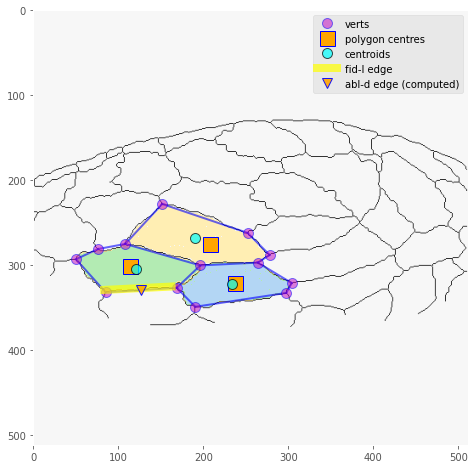

In [5]:
ROI_radius = 40# ROI radius (recommended to be approx. half edge length)
sample_name = '_'.join([Main_folder,embryo,Edge_ID])
save_dir = path.join(data_base_path,'raw',sample_name)
print('Sample:\n |',sample_name,'\nResults will be saved in\n |',save_dir)
mknewdir(save_dir)

img = read_tiff_stack(path.join(ablmov_basepath,'movies',sample_name+'.tif'),trim_bound=False)
last_mask = io.imread(path.join(ablmov_basepath,'frames_masks',sample_name+'_mask.tif'),as_gray=True)

n_frames = img.shape[0]
t = list(reversed(range(n_frames-1,-1,-10)))
img = img[t] # re-sample frames for 10s frame rate
print(f'\n---\nimg shape (resampled frames): {img.shape}\nFrames:{t}')

# Hara et al. ablated edge vertices: fiducials
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',sample_name+'_nodes.csv'))
node_tracking['frames'] = node_tracking['frames']-1 # frames start from 0


# in case if not all frames are tracked
t_frames = [node_tracking[node_tracking['frames']==k].index.values[0]
            for k in reversed(range(n_frames-1,node_tracking['frames'].iloc[0]-1,-10))]
node_tracking = node_tracking.loc[t_frames,:] # re-sample frames for 10s frame rate
node_tracking['frames'] = (node_tracking['frames'] - t[0])/10
print('\nNode tracks (w/ resampled frames):\n',node_tracking)

edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
print('\nEdge pos (x,y,t=-1):'+', '.join([f'{vi_x:.1f}' for vi_x in edge_pos]))
# Reshape dimensions for napari
abltd_verts = node_tracking.iloc[:,[0,3,2,0,5,4]].values.reshape(-1,2,3)
# order of the variables for napari : node_tracking.iloc[:,[0,3,2,0,5,4]]

print('---\nExtracting graph:')
# Approximate edge length scaling for ROI size
s=ROI_radius/np.sqrt(((node_tracking.iloc[-1,[2,3]].values- node_tracking.iloc[-1,[4,5]].values)**2).sum())
print(f'Edge scale (s):{s}')

v0_pos,edges_index,node2cell_index,(Ls_new, Cpos_new) = mask_to_graph(last_mask,
                                                             node_tracking.iloc[-1,[2,3]].values, node_tracking.iloc[-1,[4,5]].values,
                                                                     s=s)
# edge closest to the fiducials
abltd_edge_id = np.argmin(np.sum((0.5*(v0_pos[edges_index[0]]+v0_pos[edges_index[1]]) - np.array(edge_pos))**2,axis=1))
abltd_edge_pos = v0_pos[edges_index[:,abltd_edge_id]].mean(axis=0)
# edge_recoils array for saving
edge_recoils=np.empty((edges_index.shape[1],))
edge_recoils.fill(np.nan)
edge_recoils[abltd_edge_id] = edge_recoil_val
print(f'Recoils: {edge_recoils}')

cell_ids = [ci for ci in np.unique(Ls_new) if ci>0]
print(f' | #verts:{v0_pos.shape[0]}; #edges:{edges_index.shape[1]}; #cells:{len(cell_ids)} ({cell_ids})')

plt.figure(figsize=[8,8])
cmap, norm = get_cell_colormap(Ls_new.max()+3, cmap_0=(0.8, 0.8, 0.8, 0.5))

plt.imshow(last_mask,cmap='gray_r')
plt.imshow(Ls_new, cmap=cmap,norm=norm, alpha=.3)

for e in edges_index.T:
    plt.plot(v0_pos[e,0],v0_pos[e,1],'b-',lw=2,alpha=.6)
plt.plot(v0_pos[:,0],v0_pos[:,1],'mo',mec='b',ms=10,alpha=.5, label='verts')

cell_polygon_pos = np.array([v0_pos[node2cell_index[0,node2cell_index[1]==ci],:].mean(axis=0)
                             for ci in np.unique(node2cell_index[1])])
plt.plot(cell_polygon_pos[:,0],cell_polygon_pos[:,1],'s',c='orange',ms=15,mec='b',label='polygon centres')
plt.plot(Cpos_new[:,0],Cpos_new[:,1],'o',c='cyan',mec='k',ms=10,alpha=.7,label='centroids')

plt.plot(node_tracking.iloc[-1,[2,4]], node_tracking.iloc[-1,[3,5]],'-',c='yellow',lw=8,alpha=.7,label='fid-l edge')
plt.plot(abltd_edge_pos[0], abltd_edge_pos[1],'v',c='orange',ms=10,mec='b',alpha=.9,label='abl-d edge (computed)')

plt.legend();plt.grid(False);plt.show()

---
- **MANUAL VERTEX TRACKING w/ napari**:
    - Track vertices in first, middle and last frames

In [85]:
viewer = napari.view_image(img,name='movie',colormap='inferno')
# mask_layer = viewer.add_image(last_mask,name='mask',colormap='green',blending='additive',opacity=.5)
abltd_v_layer = viewer.add_shapes(abltd_verts,name='abltn',shape_type='line', edge_width=5,edge_color='red',blending='additive',opacity=.5)

# add vertices as point layers for tracking
colors= plt.cm.nipy_spectral(np.linspace(0,1,v0_pos.shape[0]))[np.random.permutation(v0_pos.shape[0])]
verts_layers = {}

verts_pos0     = np.concatenate([ np.zeros((v0_pos.shape[0],1)), v0_pos[:,[1]], v0_pos[:,[0]]],axis=1)
verts_pos_mid  = np.concatenate([ (img.shape[0]//2)*np.ones((v0_pos.shape[0],1)), v0_pos[:,[1]], v0_pos[:,[0]]],axis=1)
verts_pos_last = np.concatenate([(img.shape[0]-1)*np.ones((v0_pos.shape[0],1)), v0_pos[:,[1]], v0_pos[:,[0]]],axis=1)
verts_data = [np.stack([v0,vmid,vlast],axis=0) for v0, vmid, vlast in zip(verts_pos0, verts_pos_mid,verts_pos_last)]

for k in range(v0_pos.shape[0]):
    verts_layers[k] = viewer.add_points(verts_data[k],ndim=3,name=f'v{k}',size=3,
                                        face_color=colors[k],edge_color=colors[k],
                                        properties={'label':k*np.ones((verts_data[k].shape[0],),dtype=np.int64)},
                                        text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'})

In [116]:
v_indx =2
edges_index[:,np.logical_or(edges_index[0]==v_indx,edges_index[1]==v_indx)]

array([[2, 2],
       [3, 6]])

In [6]:
# node2cell_index[1,node2cell_index[0]==35]

In [7]:
# node2cell_index[:,node2cell_index[1]==13]

- **INTERPOLATE vertex positions for all frames**

In [117]:
t_interp = np.arange(0,img.shape[0],1)
for k in range(v0_pos.shape[0]):
    vk_name = verts_layers[k].name
    vk_data_new = np.zeros((len(t_interp),3))
    vk_data_new[:,0]= t_interp
    vk_old_data = verts_layers[k].data.copy()
    for dim in range(1,3):
        vk_data_new[:,dim] = interp1d(vk_old_data[:,0], vk_old_data[:,dim])(t_interp)
    layers_idx = [k for k,l in enumerate(viewer.layers) if l.name==vk_name][0]
    viewer.layers.pop(layers_idx)
    verts_layers[k] = viewer.add_points(vk_data_new,ndim=3,name=f'v{k}',size=3,
                                        face_color=colors[k],edge_color=colors[k],
                                        properties={'label':k*np.ones((t_interp.shape[0],),dtype=np.int64)},
                                        text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'})

In [65]:
# edges_index=np.concatenate([edges_index, np.array([[16,8],[13,19],[19,18],[18,17],[17,15]],dtype=edges_index.dtype).T],axis=1)

In [66]:
# node2cell_index=np.concatenate([node2cell_index,np.array([[k,5] for k in [12,13,19,18,17,15] ],dtype=node2cell_index.dtype).T],axis=1)

In [67]:
# new_k =21
# verts_layers[new_k] = viewer.add_points(ndim=3,name=f'v{new_k}',size=3,
#                                     face_color=colors[0],edge_color=colors[0],
#                                     properties={'label':[new_k]},
#                                     text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'})
# node2cell_index = np.concatenate([node2cell_index, np.array([[22],[7]])],axis=1)
# edges_index[:,-1] = np.array([15,21])
# edges_index = np.concatenate([edges_index, np.array([[15],[21]])],axis=1)
# edge_recoils=np.concatenate([edge_recoils, np.array([np.nan])])

---
- **SAVING tracked graphs (frames)** 
    - Copy tracked vertex positions to a new array for saving

In [118]:
verts_pos = [ verts_layers[k].data[np.argsort(verts_layers[k].data[:,0])].copy() for k in verts_layers]

# reshape to make it compatible w/ VertexDynamics dataset class
vtx_pos = np.transpose(np.stack([v_t[:,[2,1]] for v_t in verts_pos],axis=0), (1,0,2))
print(f'vtx_pos :{vtx_pos.shape}')
# print (just in case napari crashes)
verts_pos

vtx_pos :(8, 24, 2)


[array([[  0.        , 234.41136541, 368.83636398],
        [  1.        , 232.57884255, 368.96263129],
        [  2.        , 232.30727516, 368.30842086],
        [  3.        , 228.91379682, 369.2151659 ],
        [  4.        , 227.08127396, 369.34143321],
        [  5.        , 226.21407648, 368.82111472],
        [  6.        , 225.34687899, 368.30079623],
        [  7.        , 224.47968151, 367.78047774]]),
 array([[  0.        , 236.13181896, 391.90227346],
        [  1.        , 235.74926233, 391.77222264],
        [  2.        , 237.18782042, 392.68280881],
        [  3.        , 234.98414908, 391.51212101],
        [  4.        , 234.60159245, 391.38207019],
        [  5.        , 231.56640126, 391.98910843],
        [  6.        , 231.13280252, 387.91328025],
        [  7.        , 229.39840755, 386.17888528]]),
 array([[  0.        , 241.37727299, 280.14772749],
        [  1.        , 241.03295474, 279.86079562],
        [  2.        , 240.68863649, 279.57386374],
        

In [20]:
# colors= plt.cm.RdYlGn(np.linspace(0,1,len(verts_pos)))
# verts_layers = {}
# for k in range(len(verts_pos)):
#     verts_layers[k] = viewer.add_points(verts_pos[k],ndim=3,name=f'v{k}',properties={'label':k*np.ones((6,),dtype=np.int_)},
#                                         text={'text':'v{label}','size': 24,'color': 'green','anchor': 'upper_left'},
#                                         size=3,face_color=colors[k],edge_color=colors[k])

- **save vertex positions, edges and cells:**

In [119]:
# Save frames
write_array(path.join(save_dir,'frames.npy'), np.array(t) )

#vert positions array: #frames, #verts, #dims(==2)
write_array(path.join(save_dir,'vtx_pos.npy'), vtx_pos )

# edges index 2xN_edges
write_array(path.join(save_dir,'edges_index.npy'), edges_index )
# edge recoil, recoil value at ablated edge and np.nan otherwise
write_array(path.join(save_dir,'edge_recoils.npy'), edge_recoils )

# nodes to cells edges
write_array(path.join(save_dir,'node2cell_index.npy'), node2cell_index )

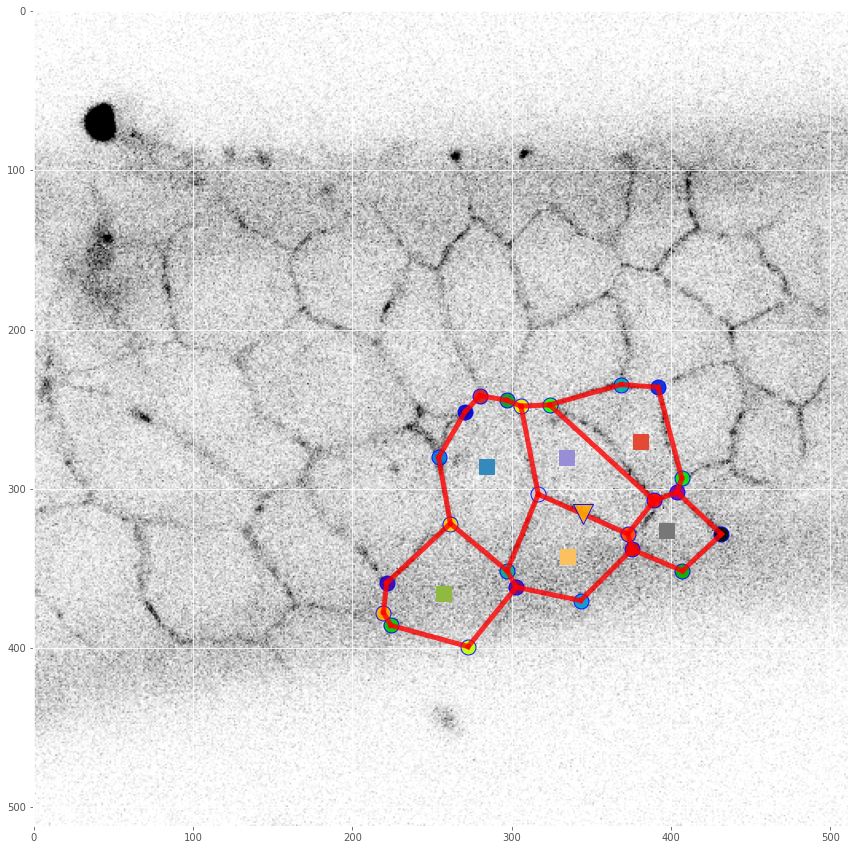

In [120]:
plt.figure(figsize=[15,15])
t_plt = 0
plt.imshow(img[t_plt],cmap='gray_r')

# colors= plt.cm.nipy_spectral(np.linspace(0,1,vtx_pos.shape[1]))[np.random.permutation(vtx_pos.shape[1])]
for k,vk in enumerate( vtx_pos[t_plt]):
    plt.plot(vk[0],vk[1],'o',c=colors[k%colors.shape[0]],mec='b',ms=15,alpha=.9)
for e in edges_index.T:
    plt.plot(vtx_pos[t_plt][e,0],vtx_pos[t_plt][e,1],'r',lw=5,alpha=.8)
    
for ci in np.unique(node2cell_index[1]):
    ci_vk = node2cell_index[0,node2cell_index[1]==ci]
    ci_pos = vtx_pos[t_plt][ci_vk,:].mean(axis=0)
    plt.plot(ci_pos[0],ci_pos[1],'s',ms=15)

# edge closest to the fiducials
# abltd_edge_id = np.argmin(np.sum((0.5*(vtx_pos[-1][edges_index[0]]+vtx_pos[-1][edges_index[1]]) - np.array(edge_pos))**2,axis=1))
abltd_edge_pos = vtx_pos[t_plt][edges_index[:,abltd_edge_id]].mean(axis=0)
plt.plot(abltd_edge_pos[0], abltd_edge_pos[1],'v',c='orange',ms=20,mec='b',alpha=.9,label='abl-d edge (computed)');

### Load check saved arrays

In [1]:
from skimage import data,io
import napari, numpy as np, glob, pandas as pd
from scipy.interpolate import interp1d
from os import path

from simgnn.datautils import write_array, load_array, mknewdir
from simgnn.hara import read_tiff_stack, mask_to_graph, get_cell_colormap

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

In [2]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

In [84]:
Main_folder = '140701_Dacat_recoil' 
embryo = 'sample2'
Edge_ID = '1'

sample_name = '_'.join([Main_folder,embryo,Edge_ID])
save_dir = path.join(data_base_path,'raw',sample_name)

recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))

edge_recoil_val = recoil_df.loc[np.logical_and( np.logical_and(recoil_df['Main folder']==Main_folder, recoil_df['embryo']==embryo),
                         recoil_df['Edge ID']==int(Edge_ID)),'Recoil speed [um/sec]'].values
print(f'Recoil: {edge_recoil_val}')
recoil_df.loc[np.logical_and( np.logical_and(recoil_df['Main folder']==Main_folder, recoil_df['embryo']==embryo),
                         recoil_df['Edge ID']==int(Edge_ID))]

Recoil: [2.44755]


,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
97,140701_Dacat_recoil,sample2,1,2.44755,-0.082071,Contracting,1.047708,1.0-1.1,False,73,4,8,NaN



Node tracks (w/ resampled frames):
     frames   t      x1      y1      x2      y2
1      0.0   2  316.50  302.50  374.25  335.00
11     1.0  12  316.00  300.50  373.75  334.75
21     2.0  22  316.25  300.50  373.00  331.25
31     3.0  32  317.00  301.75  370.50  326.00
41     4.0  42  317.50  301.25  368.75  321.00
51     5.0  52  317.75  300.25  364.75  317.75
61     6.0  62  318.00  299.25  362.25  317.25
71     7.0  72  317.75  301.25  359.50  318.25

Frame 7 : closest edge id=14; pos=([339.08944264 312.39023887])


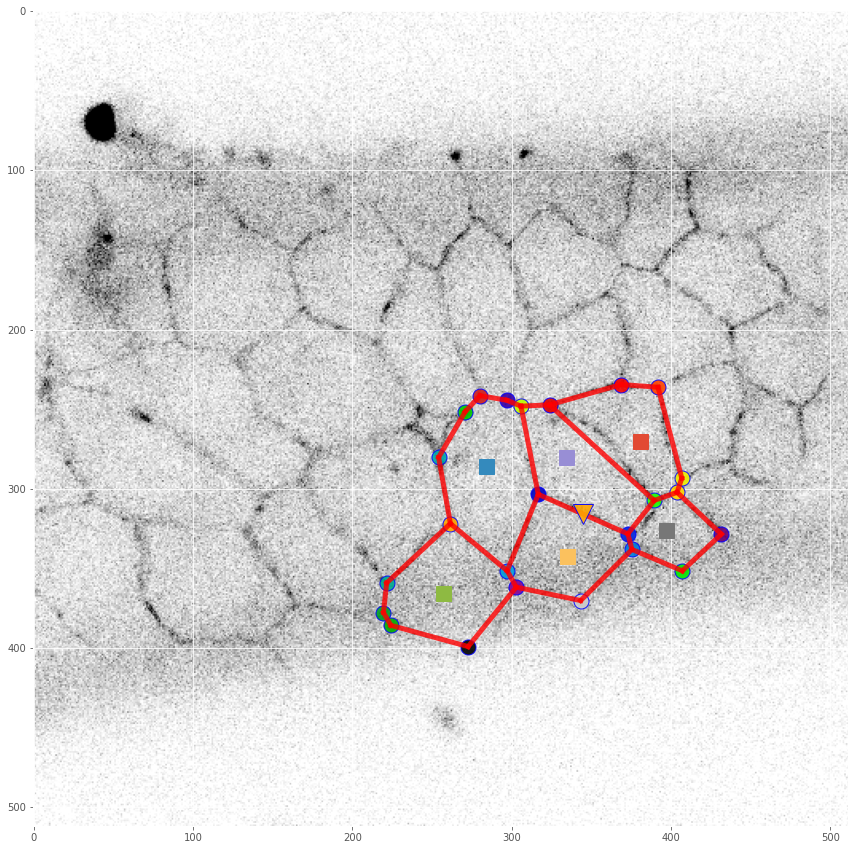

Re-computed recoils array:(29,) 
[    nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan 2.44755     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan]
Previous recoils array:(29,)
[    nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan 2.44755     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan]
Need to replace recoil array?: NO


In [86]:
# Load already saved array
t = load_array(path.join(save_dir,'frames.npy'))
vtx_pos = load_array(path.join(save_dir,'vtx_pos.npy') )
edges_index = load_array(path.join(save_dir,'edges_index.npy') )
edge_recoils = load_array(path.join(save_dir,'edge_recoils.npy') )
node2cell_index = load_array(path.join(save_dir,'node2cell_index.npy') )

# Load and re-sample raw movie frames, and load mask image
img = read_tiff_stack(path.join(ablmov_basepath,'movies',sample_name+'.tif'),trim_bound=False)
n_frames = img.shape[0]
img = img[t] # resample images
last_mask = io.imread(path.join(ablmov_basepath,'frames_masks',sample_name+'_mask.tif'),as_gray=True)

# Hara et al. ablated edge vertices: fiducials
node_tracking = pd.read_csv(path.join(data_base_path,'nodetracks',sample_name+'_nodes.csv'))
node_tracking['frames'] = node_tracking['frames']-1 # frames start from 0

# in case if not all frames are tracked
t_frames = [node_tracking[node_tracking['frames']==k].index.values[0]
            for k in reversed(range(n_frames-1,node_tracking['frames'].iloc[0]-1,-10))]
node_tracking = node_tracking.loc[t_frames,:] # re-sample frames for 10s frame rate
node_tracking['frames'] = (node_tracking['frames'] - t[0])/10
print('\nNode tracks (w/ resampled frames):\n',node_tracking)

# Find edge closest to the fiducials in Hara et al.
edge_pos = [node_tracking.iloc[-1,[2,4]].mean(), node_tracking.iloc[-1,[3,5]].mean()]
frame_i = int(node_tracking.iloc[-1,0])
abltd_edge_id = np.argmin(np.sum((0.5*(vtx_pos[frame_i][edges_index[0]]+vtx_pos[frame_i][edges_index[1]]) - np.array(edge_pos))**2,axis=1))

abltd_edge_pos_t = vtx_pos[frame_i][edges_index[:,abltd_edge_id]].mean(axis=0)
print(f'\nFrame {frame_i} : closest edge id={abltd_edge_id}; pos=({abltd_edge_pos_t})')

# # # # # # # #
# # # # # # # #

plt.figure(figsize=[15,15])
t_plt = 0
plt.imshow(img[t_plt],cmap='gray_r')
colors= plt.cm.nipy_spectral(np.linspace(0,1,vtx_pos.shape[1]))[np.random.permutation(vtx_pos.shape[1])]

# colors= plt.cm.nipy_spectral(np.linspace(0,1,vtx_pos.shape[1]))[np.random.permutation(vtx_pos.shape[1])]
for k,vk in enumerate( vtx_pos[t_plt]):
    plt.plot(vk[0],vk[1],'o',c=colors[k%colors.shape[0]],mec='b',ms=15,alpha=.9)
for e in edges_index.T:
    plt.plot(vtx_pos[t_plt][e,0],vtx_pos[t_plt][e,1],'r',lw=5,alpha=.8)
    
for ci in np.unique(node2cell_index[1]):
    ci_vk = node2cell_index[0,node2cell_index[1]==ci]
    ci_pos = vtx_pos[t_plt][ci_vk,:].mean(axis=0)
    plt.plot(ci_pos[0],ci_pos[1],'s',ms=15)

# edge closest to the fiducials
abltd_edge_pos = vtx_pos[t_plt][edges_index[:,abltd_edge_id]].mean(axis=0)
plt.plot(abltd_edge_pos[0], abltd_edge_pos[1],'v',c='orange',ms=20,mec='b',alpha=.9,label='abl-d edge (computed)');
plt.show()

# # # # #
# Check recoil array
edge_recoils_new=np.empty((edges_index.shape[1],))
edge_recoils_new.fill(np.nan)
edge_recoils_new[abltd_edge_id] = edge_recoil_val
print(f'Re-computed recoils array:{edge_recoils_new.shape} \n{edge_recoils_new}')
print(f'Previous recoils array:{edge_recoils.shape}\n{edge_recoils}')
REWRITE_RECOILS = (edge_recoils_new.shape[0] != edge_recoils.shape[0]) or (np.sum(edge_recoils == edge_recoils_new)!=1)
print(f'Need to replace recoil array?: {"YES" if REWRITE_RECOILS else "NO"}')

In [87]:
if REWRITE_RECOILS:
    print('Saved new recoils array')
    write_array(path.join(save_dir,'edge_recoils.npy'), edge_recoils_new )

### Label Rosette Movies

In [162]:
ablmov_basepath = path.abspath('../../../dataDIR/Hara_ablation_dataset')
data_base_path = './simgnn_data/hara_ablation/'

recoil_df = pd.read_csv(path.join(data_base_path,'hara_ablation_data.csv'))
recoil_df.head()

,Main folder,embryo,Edge ID,Recoil speed [um/sec],Edge Deformation [um/sec],Edge Behavior,Edge Rn,Rn Category,IsRosette,AblationFrame,# 1-neighbours,# 2-neighbours,Notes
0,140408_SqhGFP_UASDaCatRFP_c381Gal4,sample10,1,0.023877,0.020217,Expanding,1.104026,1.1-1.5,False,57,4,8,NaN
1,140411_Dacat_recoil,sample3,1,0.464255,-0.043337,Contracting,1.264302,1.1-1.5,False,47,4,9,NaN
2,140411_Dacat_recoil,sample5,1,0.452162,0.019286,Expanding,1.075047,1.0-1.1,False,50,4,8,NaN
3,140411_Dacat_recoil,sample6,1,0.283717,0.006938,Stable,1.331903,1.1-1.5,False,12,4,6,NaN
4,140415_Dacat_recoil,sample1,1,0.524569,-0.052628,Contracting,1.148226,1.1-1.5,False,30,4,8,NaN


In [163]:
raw_processed_movies = [p for p in glob.glob(path.join(data_base_path,'raw',"*")) if path.isdir(p)]
recoil_fnames = recoil_df[recoil_df['IsRosette']][['Main folder','embryo','Edge ID']].\
                apply( lambda x: '_'.join([x['Main folder'],x['embryo'],str(x['Edge ID'])]), axis=1).\
                tolist()

for p in raw_processed_movies:
    if path.basename(p) in recoil_fnames:
        write_array(path.join(p,'is_rosette.npy'),np.array([1]))
        print('Rosette:', p)
    else:
        write_array(path.join(p,'is_rosette.npy'),np.array([0]))

Rosette: ./simgnn_data/hara_ablation/raw/140529_Dacat_recoil_sample15_2
Rosette: ./simgnn_data/hara_ablation/raw/140701_Dacat_recoil_sample1_1
